<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/nlp/FineTuning_BertSequenceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizerFast, TFBertModel
from transformers import AdamWeightDecay, WarmUp
from tqdm.notebook import tqdm

## Constants

In [3]:
RANDOM_STATE = 42
MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
EPOCHS = 3
LR = 3e-5
WARMUP_PROPORTION = 0.1

## Loading Data

Using [CoLA](https://nyu-mll.github.io/CoLA/) dataset for demonstration purpose.

* Total of 10657 sentences from 23 linguistics publications. 
* Public version contains 9593 sentences belonging to training and development set. 
* 1063 holdout test set.


Data is split into an in-domain set with sentences from 17 sources and an out-of-domain set with the remaining 6 sources. The in-domain set is split into *train-dev-test* sections, and the out-of-domain set is split into *dev-test* sections. The test sets are not made public.

In [3]:
!wget -q https://nyu-mll.github.io/CoLA/cola_public_1.1.zip

In [ ]:
!unzip -q cola_public_1.1.zip

In [4]:
!ls -alth cola_public/raw/*

-rw-r--r-- 1 root root 419K Dec 14  2018 cola_public/raw/in_domain_train.tsv
-rw-r--r-- 1 root root  26K Dec 14  2018 cola_public/raw/in_domain_dev.tsv
-rw-r--r-- 1 root root  28K Dec 14  2018 cola_public/raw/out_of_domain_dev.tsv


In [5]:
cols=['source', 'label', 'notes', 'sentence']
path=Path("cola_public/raw/")
sep="\t"

In [6]:
df_train = pd.read_csv(path/"in_domain_train.tsv", sep=sep, names=cols)

In [7]:
df_val1 = pd.read_csv(path/"in_domain_dev.tsv", sep=sep, names=cols)
df_val2 = pd.read_csv(path/"out_of_domain_dev.tsv", sep=sep, names=cols)
df_val = df_val1.append(df_val2)

In [8]:
df_train.head()

,source,label,notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [9]:
print(f"Training Data: {df_train.shape}\n")
print(f"Training Data Distribution:\n{df_train['label'].value_counts()}")

Training Data: (8551, 4)

Training Data Distribution:
1    6023
0    2528
Name: label, dtype: int64


In [10]:
print(f"Validation Data: {df_val.shape}\n")
print(f"Validation Data Distribution:\n{df_val['label'].value_counts()}")

Validation Data: (1043, 4)

Validation Data Distribution:
1    719
0    324
Name: label, dtype: int64


## Training & Validation Split

In [11]:
X_train = df_train["sentence"]
y_train = df_train["label"]

X_val = df_val["sentence"]
y_val = df_val["label"]

In [12]:
print(f"Training Dataset: {X_train.shape}, {y_train.shape}")
print(f"Validation Dataset: {X_val.shape}, {y_val.shape}")

Training Dataset: (8551,), (8551,)
Validation Dataset: (1043,), (1043,)


One-hot encoding labels

In [13]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

## Tokenizing Dataset

In [14]:
!wget -q https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt

In [15]:
def preprocess(sentence, label, tokenizer):
    sentence = str(sentence.decode("utf-8"))
    sentence = " ".join(sentence.split())
    encoded = tokenizer.encode_plus(sentence,
                                    add_special_tokens=True,
                                    max_length=MAX_LEN,
                                    pad_to_max_length=True,
                                    return_attention_mask=True,
                                    truncation=True
                                    )
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    return (input_ids, attention_mask, label)

In [16]:
tokenizer = BertTokenizerFast("bert-base-uncased-vocab.txt", lowercase=True)

In [17]:
input_ids, attention_mask, label = preprocess(b"How are you?", [0, 1], tokenizer)

In [18]:
print(f"Input IDs: {input_ids}\nLength: {len(input_ids)}\n\n")
print(f"Attention Mask: {attention_mask}\nLength: {len(attention_mask)}\n\n")
print(f"Label: {label}")

Input IDs: [101, 2129, 2024, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 64


Attention Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 64


Label: [0, 1]


## DataLoader

[Akensert's Excellent Kaggle Kernel](https://www.kaggle.com/akensert/tweet-bert-base-with-tf2-1-mixed-precision/notebook)

In [19]:
class BertDataset(tf.data.Dataset):
    def _generator(sentences, labels):
        for sent, lbl in zip(sentences, labels):
            yield preprocess(sent, lbl, tokenizer)
    
    def __new__(cls, sentences, labels):
        return tf.data.Dataset.from_generator(
            cls._generator,
            args=(sentences, labels),
            output_types=(tf.dtypes.int32, tf.dtypes.int32, tf.dtypes.float32),
            output_shapes=((MAX_LEN,), (MAX_LEN,), (2,))
        )
    
    @staticmethod
    def create(sentences, labels, batch_size):
        dataset = BertDataset(
            sentences,
            labels
        )
        dataset = dataset.cache()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [20]:
train_dataset = BertDataset.create(X_train, y_train, TRAIN_BATCH_SIZE)

In [21]:
valid_dataset = BertDataset.create(X_val, y_val, EVAL_BATCH_SIZE)

## Model

In [22]:
class BertModel(tf.keras.Model):    
    def __init__(self):
        super(BertModel, self).__init__()
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")
        self.dropout = Dropout(0.3)
        self.dense = Dense(2)
    
    @tf.function 
    def call(self, inputs, training=False):
        """
        Last layer hidden-state of [CLS] token further processed by a 
        Linear layer and a Tanh activation function - (batch_size, 768) 
        """
        _, pooled_output = self.bert(inputs)
        pooled_output = self.dropout(pooled_output, 
                                     training=training)
        logits = self.dense(pooled_output)
        return logits

In [ ]:
model = BertModel()

## Sample Forward Run

In [24]:
sample_ids, sample_attn_mask, sample_labels = list(train_dataset.take(1).as_numpy_iterator())[0]

In [25]:
print(f"Sample IDs: {sample_ids.shape}")
print(f"Sample Attention Mask: {sample_attn_mask.shape}")
print(f"Sample Labels: {sample_labels.shape}")

Sample IDs: (32, 64)
Sample Attention Mask: (32, 64)
Sample Labels: (32, 2)


In [26]:
outputs = model([sample_ids, sample_attn_mask])

In [27]:
print(f"Model Outputs: {outputs.shape}")

Model Outputs: (32, 2)


## Loss Function

Binary Cross Entropy

In [28]:
binary_cross_entropy = BinaryCrossentropy(from_logits=True)
def loss_fun(targets, logits):
    return binary_cross_entropy(targets, logits)

## Training Function

In [29]:
def train_fun(dataset, model, optimizer):
    
    @tf.function
    def train_step(model, inputs, y, optimizer):
        with tf.GradientTape() as tape:
            logits = model(inputs, training=True)
            loss = loss_fun(y, logits)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, logits
    
    losses=[]
    for idx, batch in tqdm(enumerate(dataset)):
        loss, logits = train_step(model, [batch[0], batch[1]], batch[2], optimizer)
        if idx%50==0 and idx!=0:
            print(f"Batch: {idx}\tLoss: {np.mean(losses)}")
        losses.append(loss)

## Evaluation Function

In [30]:
def eval_fun(dataset, model):
    outputs = []
    preds = []
    actuals = []
    losses = []
    @tf.function
    def eval_step(model, inputs, y):
        logits = model(inputs, training=True)
        loss = loss_fun(y, logits)
        return logits, loss, y
   
    for idx, batch in tqdm(enumerate(dataset)):
        logits, loss, y = eval_step(model, [batch[0], batch[1]], batch[2])
        outputs.append(logits)
        actuals.append(y)
        losses.append(loss)
        preds.append(np.argmax(logits, axis=1).flatten())
    return outputs, losses, preds, actuals

## Optimizer & Scheduler

In [31]:
num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE*EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [32]:
num_train_steps, num_warmup_steps

(801, 80)

In [33]:
def linear_scheduler(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_train_steps - current_step) / float(max(1, num_train_steps - num_warmup_steps)))

In [34]:
vals = [linear_scheduler(x) for x in range(0, num_train_steps)]

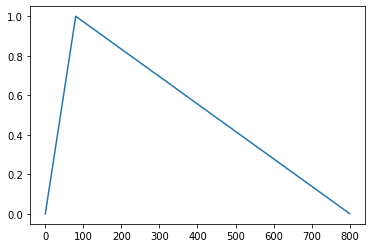

In [35]:
_ = plt.plot(range(0, num_train_steps), vals)

In [36]:
warmup = WarmUp(initial_learning_rate=LR,
                decay_schedule_fn=linear_scheduler,
                warmup_steps=num_warmup_steps)

In [37]:
optimizer = AdamWeightDecay(learning_rate=LR)

## Training

In [38]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_fun(train_dataset, model, optimizer)
    outputs, losses, preds, actuals = eval_fun(valid_dataset, model)
    actuals = [item.numpy() for sublist in actuals for item in sublist]
    preds = [item for sublist in preds for item in sublist]
    print(f"Validation Accuracy: {accuracy_score(np.argmax(actuals, axis=1).flatten(), preds)}")
    print(f"Validation MCC: {matthews_corrcoef(np.argmax(actuals, axis=1).flatten(), preds)}")
    print(f"Validation Loss: {np.mean(losses)}\n")

Epoch 1/3


Batch: 50	Loss: 0.6770665645599365
Batch: 100	Loss: 0.6405757665634155
Batch: 150	Loss: 0.5946382880210876
Batch: 200	Loss: 0.5542846918106079
Batch: 250	Loss: 0.5306946635246277




Validation Accuracy: 0.7766059443911792
Validation MCC: 0.43861130962529987
Validation Loss: 0.491455078125

Epoch 2/3


Batch: 50	Loss: 0.49968528747558594
Batch: 100	Loss: 0.4455820918083191
Batch: 150	Loss: 0.394610196352005
Batch: 200	Loss: 0.36159178614616394
Batch: 250	Loss: 0.34137946367263794




Validation Accuracy: 0.8111217641418984
Validation MCC: 0.5370706108577712
Validation Loss: 0.4963570535182953

Epoch 3/3


Batch: 50	Loss: 0.32712432742118835
Batch: 100	Loss: 0.27894333004951477
Batch: 150	Loss: 0.24373014271259308
Batch: 200	Loss: 0.23147399723529816
Batch: 250	Loss: 0.2218448519706726




Validation Accuracy: 0.8053691275167785
Validation MCC: 0.5386235923206266
Validation Loss: 0.4609832465648651



## Testing

Kaggle had hosted the competition [here](https://www.kaggle.com/c/cola-in-domain-open-evaluation/) for evaluation on **in-domain** hold out test set

In [39]:
df_test = pd.read_csv("cola_in_domain_test.tsv", sep=sep)

In [40]:
df_test.shape

(530, 2)

In [41]:
df_test.head()

,Id,Sentence
0,1,Bill whistled past the house.
1,2,The car honked its way down the road.
2,3,Bill pushed Harry off the sofa.
3,4,the kittens yawned awake and played.
4,5,"I demand that the more John eats, the more he ..."


In [42]:
test_dataset = BertDataset.create(df_test["Sentence"].values, 
                                  [[0,1]]*len(df_test), 
                                  EVAL_BATCH_SIZE)

In [43]:
outputs, losses, preds, actuals = eval_fun(test_dataset, model)
preds = [item for sublist in preds for item in sublist]

In [44]:
df_test["Label"] = preds

In [45]:
df_test["Label"].value_counts()

1    389
0    141
Name: Label, dtype: int64

In [46]:
pd.set_option("display.max_colwidth", 300)

Checking if the label looks correct for the first 10 sentences

In [47]:
df_test.head(10)

,Id,Sentence,Label
0,1,Bill whistled past the house.,1
1,2,The car honked its way down the road.,1
2,3,Bill pushed Harry off the sofa.,1
3,4,the kittens yawned awake and played.,1
4,5,"I demand that the more John eats, the more he pay.",0
5,6,"If John eats more, keep your mouth shut tighter, OK?",1
6,7,His expectations are always lower than mine are.,1
7,8,"The sooner you call, the more carefully I will word the letter.",0
8,9,"The more timid he feels, the more people he interviews without asking questions of.",0
9,10,"Once Janet left, Fred became a lot crazier.",1


In [48]:
df_test[["Id", "Label"]].to_csv("sample_submission_1.csv", index=False)

On submission on Kaggle, achieved **0.52648** score. Achieved **33rd** position on public leaderboard. Not too bad, considering that no hyperparameter tuning was done!

Similarly, there's another [competition](), which evaluates on **out-of-domain** hold out test set

In [50]:
df_test = pd.read_csv("cola_out_of_domain_test.tsv", sep=sep)

In [51]:
test_dataset = BertDataset.create(df_test["Sentence"].values, 
                                  [[0,1]]*len(df_test), 
                                  EVAL_BATCH_SIZE)

In [52]:
outputs, losses, preds, actuals = eval_fun(test_dataset, model)
preds = [item for sublist in preds for item in sublist]

In [53]:
df_test["Label"] = preds
df_test["Label"].value_counts()

1    368
0    165
Name: Label, dtype: int64

In [54]:
df_test.head()

,Id,Sentence,Label
0,1,"They claimed they had settled on something, but it wasn't clear what.",1
1,2,Somebody just left - guess who just left.,1
2,3,"This opera was written in the 19th century, but we're not sure by whom.",1
3,4,"He's going to give us one old problem for the test, but which problem isn't clear.",1
4,5,She's reading something. I can't imagine what.,1


In [55]:
df_test[["Id", "Label"]].to_csv("sample_submission_2.csv", index=False)